In [3]:
# pyarrow might be needed to read the data
!python -m pip install Cython
!python -m pip install -e git+https://git@github.com/alercebroker/turbo-fats#egg=turbofats
!python -m pip install -e git+https://git@github.com/alercebroker/mhps#egg=mhps
!python -m pip install -e git+https://git@github.com/alercebroker/P4J#egg=P4J
!python -m pip install pyarrow
!python -m pip install -e git+https://git@github.com/alercebroker/lc_classifier#egg=lc_classifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining turbofats from git+https://****@github.com/alercebroker/turbo-fats#egg=turbofats
  Cloning https://****@github.com/alercebroker/turbo-fats to ./src/turbofats
  Running command git clone -q 'https://****@github.com/alercebroker/turbo-fats' /content/src/turbofats
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 318, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.8/dist-pac

# Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lc_classifier.utils import LightcurveBuilder


In [3]:
pathData =  "/content/drive/MyDrive/ColabNotebooks/InteligenciaComputacional/Projeto/Dados/"

!ls /content/drive/MyDrive/ColabNotebooks/InteligenciaComputacional/Projeto/Dados/

detections_SNe_v7.0.1.csv		  features_preprocessed.csv
detections_SNe_v7.0.1.gsheet		  features_raw_both_bands.csv
dfcrossmatches_prioritized_v7.0.1.csv	  features_raw.csv
dfcrossmatches_prioritized_v7.0.1.gsheet


In [ ]:
# read the datasets
df_crossmatches = pd.read_csv(pathData+"dfcrossmatches_prioritized_v7.0.1.csv")
df_detections = pd.read_csv(pathData+"detections_SNe_v7.0.1.csv")

## Join Data

In [ ]:
# print the datasets
df_crossmatches.set_index('oid')
df_detections.set_index('objectId')
#df_joined = pd.concat([df_crossmatches, df_detections], axis=1, join='inner')
df_joined = pd.merge(df_crossmatches, df_detections, left_on='oid', right_on='objectId')
df_joined.pop('Unnamed: 0')
#df_joined.rename(columns = {'Unnamed: 0':'key'}, inplace = True)
print(df_joined)

Removing columns with data that we will not use

In [ ]:
df_joined = df_joined[['oid', 'classALeRCE', 'fid', 'mjd', 'magpsf_corr', 'sigmapsf_corr']]

print("Removed useless columns")

print(df_joined)

Removed band with less samples

In [ ]:
#drop rows that contain specific 'value' in 'column_name'
df_oneBand = df_joined[df_joined.fid == 2]
df_oneBand = df_joined

print(df_oneBand)

Removed rows with NaN on magnitude and error since these do not provide aditional value.

In [ ]:
df_oneBand_noNaN = df_oneBand.dropna(subset=["magpsf_corr","sigmapsf_corr"])
df_oneBand_noNaN.rename(columns = {'fid':'band','mjd':'time','magpsf_corr':'magnitude','sigmapsf_corr':'error'}, inplace = True)
print(df_oneBand_noNaN)
df_oneBand_noNaN.set_index('oid')

Removed rows with error equal to 100 because that data isnt relevant


In [ ]:
df_oneBand_noNaN = df_oneBand_noNaN[df_oneBand_noNaN.error != 100.000000]
df_oneBand_noNaN

## Feature Extractor

In [ ]:
bands = [1,2]

#n_curves = len(pd.unique(df_oneBand_noNaN['oid']))
#n_curves = len(df_oneBand_noNaN)
df_grouped = df_oneBand_noNaN.groupby('oid')

lightcurves = []
# iterate over each group
for group_name, df_group in df_grouped:

    lightcurve_builder = LightcurveBuilder(f'{group_name}')
    band = []
    #band = bands[0]
    time = []
    magnitude = []
    error = []
    # iterate over each lightcurve with same id and fill vectors
    for row_index, row in df_group.iterrows():
      for current_band in bands: # TODO not done correctly for bands
        band.append(row['band'])
        time.append(row['time'])
        magnitude.append(row['magnitude'])
        error.append(row['error'])

    # builds the lightcurve with vectors
    lightcurve_builder.add_band(
        band,
        time,
        magnitude,
        error)

    lightcurve = lightcurve_builder.build_dataframe()
    lightcurves.append(lightcurve)
lightcurves = pd.concat(lightcurves)
lightcurves


In [ ]:
cnt = 0
for row_index, curve in lightcurves.iterrows():
  if int(curve['band']) == 1:
    cnt+=1
print('Number of band 1: '+str(cnt))

Plotting the light curve

In [ ]:
fig = plt.figure(figsize=(10, 12))
fig.set_facecolor('white')
bands = [2]
plt.subplot(2, 1, 1)
for band in bands:
    obs_in_band = lightcurves[lightcurves.band == band]
    plt.errorbar(
        obs_in_band.time,
        obs_in_band.magnitude,
        yerr=obs_in_band.error,
        fmt='.',
        label=band
    )

plt.xlabel('Time [days]')
plt.ylabel('Magnitude')
plt.title('Synthetic light curve')
plt.legend()
plt.gca().invert_yaxis()
'''
plt.subplot(2, 1, 2)
for band in bands:
    obs_in_band = lightcurves[lightcurves.band == band]
    plt.errorbar(
        (obs_in_band.time % true_period) / true_period * 2 * np.pi,
        obs_in_band.magnitude,
        yerr=obs_in_band.error,
        fmt='.',
        label=band
    )

plt.xlabel('Phase [radians]')
plt.ylabel('Magnitude')
plt.title(f'Folded light curve (Period {true_period:.3f} days)')
plt.legend()
plt.gca().invert_yaxis()

plt.show()
'''

In [ ]:
from lc_classifier.features import MHPSExtractor, PeriodExtractor, GPDRWExtractor
from lc_classifier.features import FoldedKimExtractor
from lc_classifier.features import HarmonicsExtractor, IQRExtractor
from lc_classifier.features import PowerRateExtractor
from lc_classifier.features import TurboFatsFeatureExtractor

from lc_classifier.features import FeatureExtractorComposer

In [ ]:
bands = [1,2]

feature_extractor = FeatureExtractorComposer(
    [
        MHPSExtractor(bands),
        PeriodExtractor(bands),
        GPDRWExtractor(bands),
        FoldedKimExtractor(bands),
        HarmonicsExtractor(bands),
        IQRExtractor(bands),
        PowerRateExtractor(bands),
        TurboFatsFeatureExtractor(bands)
    ]
)

In [ ]:
features = feature_extractor.compute_features(lightcurves)
features

In [ ]:
features_cpy=features
df_noDup=df_oneBand_noNaN.drop_duplicates(subset=['oid'])

features_class=pd.merge(features,df_noDup[['oid','classALeRCE']],left_on='oid',right_on='oid',how='right')
print(features_class.head())

In [ ]:
features_class.to_csv(pathData+'features_raw_both_bands.csv', encoding='utf-8', index=True)

## Read Features Raw CSV

In [4]:
import time
t1 = time.perf_counter()



In [5]:
features_raw = pd.read_csv(pathData + 'features_raw.csv')
features_raw.pop('Unnamed: 0')
features_raw

,oid,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,MHPS_non_zero_2,MHPS_PN_flag_2,Multiband_period,PPE,Period_band_2,delta_period_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
0,ZTF18acqyvag,22.090452,0.083888,0.003797,5.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SLSN
1,ZTF18acenqto,1.452479,0.090188,0.062092,70.0,1.0,0.998738,0.096247,999.999953,999.001214,...,1.385767,1.080584,0.922808,1.0,0.000611,-0.500000,-0.500000,0.998053,0.008624,SLSN
2,ZTF18abshezu,536.331787,6.329177,0.011801,30.0,0.0,1.003062,0.048588,999.999953,998.996891,...,-0.811784,0.517986,0.861637,1.0,0.000755,1.835929,0.439041,0.986716,-0.011949,SLSN
3,ZTF18abslpjy,88.861420,20.370335,0.229237,82.0,1.0,283.582089,0.021843,283.582089,0.000000,...,0.010128,1.562817,0.831060,1.0,-0.187700,-0.500000,-0.500000,0.997851,0.005057,SLSN
4,ZTF19aanesgt,10.716300,0.186683,0.017420,14.0,0.0,0.185142,0.035135,0.185142,0.000000,...,-0.831149,0.262021,0.877776,1.0,0.000174,0.811234,0.277575,0.879367,-0.000478,SLSN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,ZTF20aalxlis,281.336578,23.224478,0.082551,48.0,0.0,206.521717,0.060233,206.521717,0.000000,...,-0.759402,0.884755,0.856525,1.0,0.002389,11.683791,1.178610,0.993593,0.021451,SNIbc
724,ZTF20aavcvrm,110.814598,2.192782,0.019788,60.0,0.0,50.397874,0.033728,50.397874,0.000000,...,-1.447639,0.455516,0.897520,1.0,0.000503,4.595963,0.645265,0.971963,0.020873,SNIbc
725,ZTF20aaurexl,545.559204,17.033440,0.031222,60.0,0.0,102.702699,0.085322,102.702699,0.000000,...,-1.076949,0.688289,0.925710,1.0,0.001222,14.218827,1.104718,0.992106,0.030587,SNIbc
726,ZTF19aanmzsb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SNIbc


## Visualize and Analyse Data

### Class Imbalance

In [6]:
pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


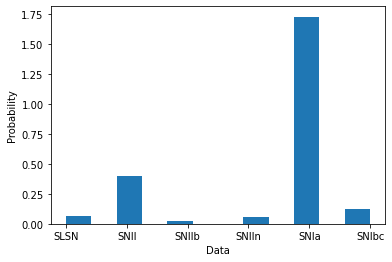

In [7]:
%matplotlib inline

classes = features_raw.classALeRCE.values

x = classes

plt.hist(x, density=True, bins=12)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

- As we can see data is quite **unbalanced**, so we should aim to balance it further ahead.

### Missing Data

oid                    0
MHPS_ratio_2         130
MHPS_low_2           130
MHPS_high_2          130
MHPS_non_zero_2      130
                    ... 
SF_ML_amplitude_2    171
SF_ML_gamma_2        171
IAR_phi_2            171
LinearTrend_2        171
classALeRCE            0
Length: 62, dtype: int64

Features with max NaNs:
Eta_e_2


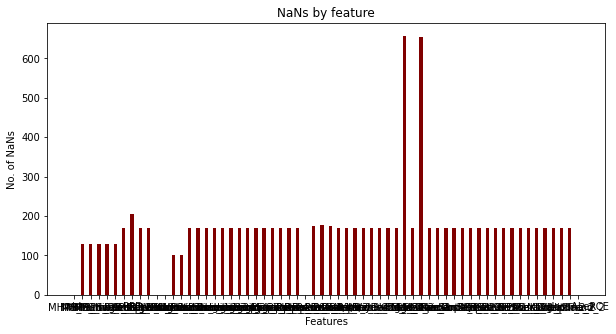

In [8]:
nan_data = features_raw.isna().sum()
print(nan_data)

indexes = []
for i in range(0,len(nan_data)):
  if nan_data[i]==max(nan_data):
      indexes.append(i)

y = nan_data
x = list(features_raw.columns)

print("\nFeatures with max NaNs:")
for i in indexes:
  print(x[i])

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("No. of NaNs")
plt.title("NaNs by feature")
plt.show()

From this plot we can clearly see that there are two atributes named *Eta_e_2* and *MaxSlope_2* with almost all values as *NaN*, as such these have no real value and will be removed further down the line

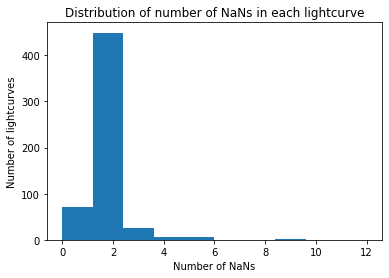

In [9]:
rows_w_nan = features_raw.isnull().any(axis=1).sum()

percentage_rows_w_nan = rows_w_nan/len(features_raw)*100

#print('Percentage of Rows with atleast one NaN: ' + str(percentage_rows_w_nan) + '%')

row_num_of_nans = features_raw.isnull().sum(axis=1)
#print('\n\n')

x = classes

plt.hist(row_num_of_nans, density=False, bins=10, range=(0,12))  # density=False would make counts
plt.title('Distribution of number of NaNs in each lightcurve')
plt.ylabel('Number of lightcurves')
plt.xlabel('Number of NaNs');

Same plot but with diferent scale...



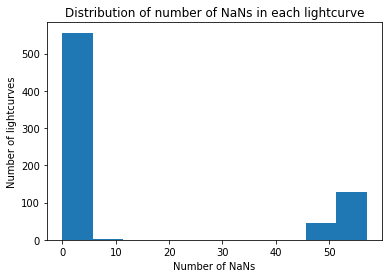

In [10]:
print('Same plot but with diferent scale...\n')

plt.hist(row_num_of_nans, density=False, bins=10)  # density=False would make counts
plt.title('Distribution of number of NaNs in each lightcurve')
plt.ylabel('Number of lightcurves')
plt.xlabel('Number of NaNs');

As such we can see that a lot of NaNs are present so we cannot simply eliminate rows with NaNs otherwise we would only have left a very small portion of our data.

So maybe only eliminating those with a lot of NaNs makes more sense, and keeping those with less NaNs, for example deleting the lightcurves with more than 40 NaNs being that there is a total of 62 atributes.

## Preprocess Data

### Class Imbalance

We will be joining classes *SNII*, *SNIIb*, *SNIIn* and treating them as a new class *SNII_Joined*, this way our classes will be at least a little more balanced.

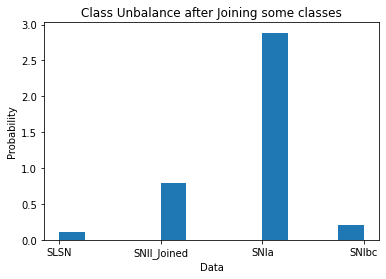

In [11]:
# Applying the condition
features_raw.loc[features_raw["classALeRCE"] == "SNII", "classALeRCE"] = "SNII_Joined"
features_raw.loc[features_raw["classALeRCE"] == "SNIIb", "classALeRCE"] = "SNII_Joined"
features_raw.loc[features_raw["classALeRCE"] == "SNIIn", "classALeRCE"] = "SNII_Joined"


# New plot of class imbalance
%matplotlib inline

classes = features_raw.classALeRCE.values

x = classes

plt.hist(x, density=True, bins=12)  # density=False would make counts
plt.title('Class Unbalance after Joining some classes')
plt.ylabel('Probability')
plt.xlabel('Data');

### Remove some NaNs

As previously discussed, there are two atributes named *Eta_e_2* and *MaxSlope_2* with almost all values as *NaN*, as such these have no real value and will be removed.

In [12]:
features_pop = features_raw.copy()

#features_pop.pop('Eta_e_1')
#features_pop.pop('MaxSlope_1')
features_pop.pop('MaxSlope_2')
features_pop.pop('Eta_e_2')

features_pop

,oid,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,MHPS_non_zero_2,MHPS_PN_flag_2,Multiband_period,PPE,Period_band_2,delta_period_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
0,ZTF18acqyvag,22.090452,0.083888,0.003797,5.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SLSN
1,ZTF18acenqto,1.452479,0.090188,0.062092,70.0,1.0,0.998738,0.096247,999.999953,999.001214,...,1.385767,1.080584,0.922808,1.0,0.000611,-0.500000,-0.500000,0.998053,0.008624,SLSN
2,ZTF18abshezu,536.331787,6.329177,0.011801,30.0,0.0,1.003062,0.048588,999.999953,998.996891,...,-0.811784,0.517986,0.861637,1.0,0.000755,1.835929,0.439041,0.986716,-0.011949,SLSN
3,ZTF18abslpjy,88.861420,20.370335,0.229237,82.0,1.0,283.582089,0.021843,283.582089,0.000000,...,0.010128,1.562817,0.831060,1.0,-0.187700,-0.500000,-0.500000,0.997851,0.005057,SLSN
4,ZTF19aanesgt,10.716300,0.186683,0.017420,14.0,0.0,0.185142,0.035135,0.185142,0.000000,...,-0.831149,0.262021,0.877776,1.0,0.000174,0.811234,0.277575,0.879367,-0.000478,SLSN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,ZTF20aalxlis,281.336578,23.224478,0.082551,48.0,0.0,206.521717,0.060233,206.521717,0.000000,...,-0.759402,0.884755,0.856525,1.0,0.002389,11.683791,1.178610,0.993593,0.021451,SNIbc
724,ZTF20aavcvrm,110.814598,2.192782,0.019788,60.0,0.0,50.397874,0.033728,50.397874,0.000000,...,-1.447639,0.455516,0.897520,1.0,0.000503,4.595963,0.645265,0.971963,0.020873,SNIbc
725,ZTF20aaurexl,545.559204,17.033440,0.031222,60.0,0.0,102.702699,0.085322,102.702699,0.000000,...,-1.076949,0.688289,0.925710,1.0,0.001222,14.218827,1.104718,0.992106,0.030587,SNIbc
726,ZTF19aanmzsb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SNIbc


Now we can see that there are no more atribute outliers in terms of NaNs.

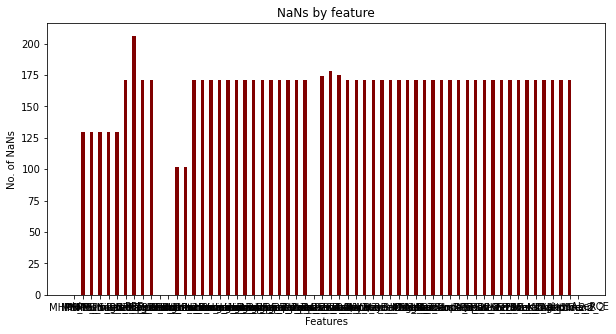

In [13]:
nan_data = features_pop.isna().sum()
#print(nan_data)
y = nan_data
x = list(features_pop.columns)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("No. of NaNs")
plt.title("NaNs by feature")
plt.show()

Now we will remove the lightcurves with more than 60% of the atributes as NaNs since these do not provide much real value

In [14]:
features_no_big_nan = features_pop[features_pop.isnull().sum(axis=1) < 40]

features_no_big_nan

,oid,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,MHPS_non_zero_2,MHPS_PN_flag_2,Multiband_period,PPE,Period_band_2,delta_period_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
1,ZTF18acenqto,1.452479,0.090188,0.062092,70.0,1.0,0.998738,0.096247,999.999953,999.001214,...,1.385767,1.080584,0.922808,1.0,0.000611,-0.500000,-0.500000,0.998053,0.008624,SLSN
2,ZTF18abshezu,536.331787,6.329177,0.011801,30.0,0.0,1.003062,0.048588,999.999953,998.996891,...,-0.811784,0.517986,0.861637,1.0,0.000755,1.835929,0.439041,0.986716,-0.011949,SLSN
3,ZTF18abslpjy,88.861420,20.370335,0.229237,82.0,1.0,283.582089,0.021843,283.582089,0.000000,...,0.010128,1.562817,0.831060,1.0,-0.187700,-0.500000,-0.500000,0.997851,0.005057,SLSN
4,ZTF19aanesgt,10.716300,0.186683,0.017420,14.0,0.0,0.185142,0.035135,0.185142,0.000000,...,-0.831149,0.262021,0.877776,1.0,0.000174,0.811234,0.277575,0.879367,-0.000478,SLSN
5,ZTF18acyxnyw,506.537109,2.918541,0.005762,44.0,1.0,197.916661,0.019501,197.916661,0.000000,...,-0.712791,0.350003,0.803699,1.0,0.000319,1.587449,0.677863,0.984893,0.006356,SLSN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,ZTF19abqwtfu,609.013855,8.720496,0.014319,96.0,0.0,199.999986,0.021373,199.999986,0.000000,...,-1.089584,0.839050,0.919236,1.0,0.002301,5.903105,0.804971,0.992911,0.017891,SNIbc
723,ZTF20aalxlis,281.336578,23.224478,0.082551,48.0,0.0,206.521717,0.060233,206.521717,0.000000,...,-0.759402,0.884755,0.856525,1.0,0.002389,11.683791,1.178610,0.993593,0.021451,SNIbc
724,ZTF20aavcvrm,110.814598,2.192782,0.019788,60.0,0.0,50.397874,0.033728,50.397874,0.000000,...,-1.447639,0.455516,0.897520,1.0,0.000503,4.595963,0.645265,0.971963,0.020873,SNIbc
725,ZTF20aaurexl,545.559204,17.033440,0.031222,60.0,0.0,102.702699,0.085322,102.702699,0.000000,...,-1.076949,0.688289,0.925710,1.0,0.001222,14.218827,1.104718,0.992106,0.030587,SNIbc


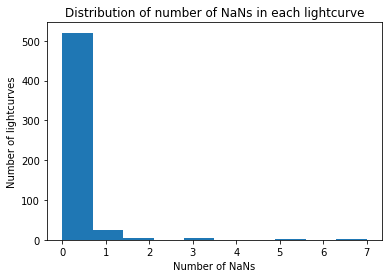

In [15]:
rows_w_nan = features_no_big_nan.isnull().any(axis=1).sum()

percentage_rows_w_nan = rows_w_nan/len(features_no_big_nan)*100

#print('Percentage of Rows with atleast one NaN: ' + str(percentage_rows_w_nan) + '%')

row_num_of_nans = features_no_big_nan.isnull().sum(axis=1)
#print('\n\n')

plt.hist(row_num_of_nans, density=False, bins=10)  # density=False would make counts
plt.title('Distribution of number of NaNs in each lightcurve')
plt.ylabel('Number of lightcurves')
plt.xlabel('Number of NaNs');

oid                     0
MHPS_ratio_2            3
MHPS_low_2              3
MHPS_high_2             3
MHPS_non_zero_2         3
MHPS_PN_flag_2          3
Multiband_period        0
PPE                    35
Period_band_2           0
delta_period_2          0
GP_DRW_sigma_2          0
GP_DRW_tau_2            0
Psi_CS_2                0
Psi_eta_2               0
Harmonics_mag_1_2       0
Harmonics_mag_2_2       0
Harmonics_mag_3_2       0
Harmonics_mag_4_2       0
Harmonics_mag_5_2       0
Harmonics_mag_6_2       0
Harmonics_mag_7_2       0
Harmonics_phase_2_2     0
Harmonics_phase_3_2     0
Harmonics_phase_4_2     0
Harmonics_phase_5_2     0
Harmonics_phase_6_2     0
Harmonics_phase_7_2     0
Harmonics_mse_2         0
iqr_2                   0
Power_rate_1/4          3
Power_rate_1/3          7
Power_rate_1/2          4
Power_rate_2            0
Power_rate_3            0
Power_rate_4            0
Amplitude_2             0
AndersonDarling_2       0
Autocor_length_2        0
Beyond1Std_2

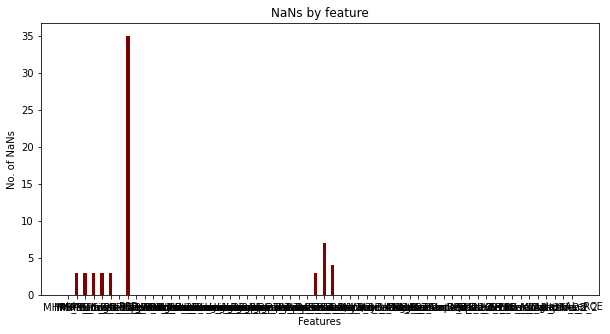

In [16]:
nan_data = features_no_big_nan.isna().sum()
print(nan_data)
y = nan_data
x = list(features_no_big_nan.columns)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("No. of NaNs")
plt.title("NaNs by feature")
plt.show()

Now we can see that only a few atributes with NaNs are left and even these have few NaNs, the most has around 50 which is still a relatively acceptable number.

So now we must fill these NaN values, there are several possible methods but we choose to use the average of that column in order to fill these NaNs, so as to not have much impact in the results.

### Normalize

In [17]:
#normalized_features=(features_no_big_nan-features_no_big_nan.mean())/features_no_big_nan.std()
#normalized_features

normalized_only_features = features_no_big_nan.select_dtypes(include='number')

normalized_only_features = (normalized_only_features - normalized_only_features.mean()) / (normalized_only_features.max() - normalized_only_features.min())


features_no_big_nan[normalized_only_features.columns] = normalized_only_features

normalized_features = features_no_big_nan.copy()

normalized_features

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,oid,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,MHPS_non_zero_2,MHPS_PN_flag_2,Multiband_period,PPE,Period_band_2,delta_period_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
1,ZTF18acenqto,-0.004860,-0.063240,0.009914,0.068442,0.882671,-0.055497,0.043921,0.878707,0.915068,...,0.120907,0.360018,0.205376,0.020977,0.002151,-0.268524,-0.334374,0.112235,-0.008429,SLSN
2,ZTF18abshezu,-0.003225,0.075972,-0.007896,-0.006887,-0.117329,-0.055491,-0.028093,0.878707,0.915064,...,-0.063982,0.077676,0.056584,0.020977,0.002271,-0.117819,-0.033691,0.100898,-0.163905,SLSN
3,ZTF18abslpjy,-0.004593,0.389278,0.069107,0.091041,0.882671,0.375847,-0.068505,0.162253,-0.083986,...,0.005169,0.602029,-0.017791,0.020977,-0.155118,-0.268524,-0.334374,0.112033,-0.035384,SLSN
4,ZTF19aanesgt,-0.004832,-0.061087,-0.005906,-0.037019,-0.117329,-0.056739,-0.048421,-0.121158,-0.083986,...,-0.065612,-0.050781,0.095840,0.020977,0.001786,-0.183929,-0.085392,-0.006451,-0.077210,SLSN
5,ZTF18acyxnyw,-0.003316,-0.000130,-0.010034,0.019478,0.882671,0.245085,-0.072044,0.076583,-0.083986,...,-0.055654,-0.006627,-0.084346,0.020977,0.001907,-0.133850,0.042780,0.099075,-0.025566,SLSN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,ZTF19abqwtfu,-0.003003,0.129331,-0.007004,0.117407,-0.117329,0.248265,-0.069216,0.078667,-0.083986,...,-0.087355,0.238803,0.196688,0.020977,0.003562,0.144579,0.083481,0.107093,0.061610,SNIbc
723,ZTF20aalxlis,-0.004005,0.452964,0.017159,0.027011,-0.117329,0.258220,-0.010498,0.085189,-0.083986,...,-0.059575,0.261741,0.044148,0.020977,0.003636,0.517527,0.203121,0.107775,0.088514,SNIbc
724,ZTF20aavcvrm,-0.004526,-0.016324,-0.005067,0.049610,-0.117329,0.019907,-0.050547,-0.070943,-0.083986,...,-0.117479,0.046325,0.143867,0.020977,0.002061,0.060247,0.032343,0.086145,0.084141,SNIbc
725,ZTF20aaurexl,-0.003197,0.314821,-0.001018,0.049610,-0.117329,0.099747,0.027412,-0.018635,-0.083986,...,-0.086292,0.163144,0.212436,0.020977,0.002661,0.681077,0.179460,0.106288,0.157557,SNIbc


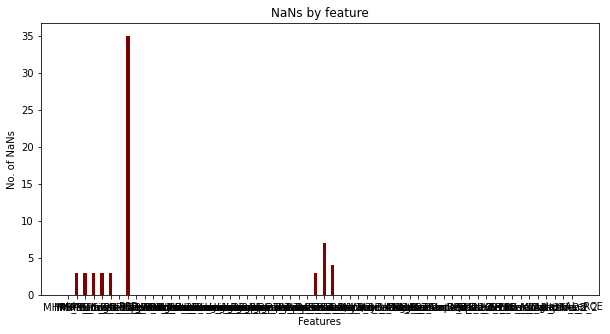

In [18]:
nan_data = normalized_features.isna().sum()
#print(nan_data)
y = nan_data
x = list(normalized_features.columns)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("No. of NaNs")
plt.title("NaNs by feature")
plt.show()

### Fill Remaining NaNs

In [19]:
features_nan_filled = normalized_features.fillna(normalized_features.mean())

features_nan_filled

<ipython-input-19-9959d51062f5>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features_nan_filled = normalized_features.fillna(normalized_features.mean())


,oid,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,MHPS_non_zero_2,MHPS_PN_flag_2,Multiband_period,PPE,Period_band_2,delta_period_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
1,ZTF18acenqto,-0.004860,-0.063240,0.009914,0.068442,0.882671,-0.055497,0.043921,0.878707,0.915068,...,0.120907,0.360018,0.205376,0.020977,0.002151,-0.268524,-0.334374,0.112235,-0.008429,SLSN
2,ZTF18abshezu,-0.003225,0.075972,-0.007896,-0.006887,-0.117329,-0.055491,-0.028093,0.878707,0.915064,...,-0.063982,0.077676,0.056584,0.020977,0.002271,-0.117819,-0.033691,0.100898,-0.163905,SLSN
3,ZTF18abslpjy,-0.004593,0.389278,0.069107,0.091041,0.882671,0.375847,-0.068505,0.162253,-0.083986,...,0.005169,0.602029,-0.017791,0.020977,-0.155118,-0.268524,-0.334374,0.112033,-0.035384,SLSN
4,ZTF19aanesgt,-0.004832,-0.061087,-0.005906,-0.037019,-0.117329,-0.056739,-0.048421,-0.121158,-0.083986,...,-0.065612,-0.050781,0.095840,0.020977,0.001786,-0.183929,-0.085392,-0.006451,-0.077210,SLSN
5,ZTF18acyxnyw,-0.003316,-0.000130,-0.010034,0.019478,0.882671,0.245085,-0.072044,0.076583,-0.083986,...,-0.055654,-0.006627,-0.084346,0.020977,0.001907,-0.133850,0.042780,0.099075,-0.025566,SLSN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,ZTF19abqwtfu,-0.003003,0.129331,-0.007004,0.117407,-0.117329,0.248265,-0.069216,0.078667,-0.083986,...,-0.087355,0.238803,0.196688,0.020977,0.003562,0.144579,0.083481,0.107093,0.061610,SNIbc
723,ZTF20aalxlis,-0.004005,0.452964,0.017159,0.027011,-0.117329,0.258220,-0.010498,0.085189,-0.083986,...,-0.059575,0.261741,0.044148,0.020977,0.003636,0.517527,0.203121,0.107775,0.088514,SNIbc
724,ZTF20aavcvrm,-0.004526,-0.016324,-0.005067,0.049610,-0.117329,0.019907,-0.050547,-0.070943,-0.083986,...,-0.117479,0.046325,0.143867,0.020977,0.002061,0.060247,0.032343,0.086145,0.084141,SNIbc
725,ZTF20aaurexl,-0.003197,0.314821,-0.001018,0.049610,-0.117329,0.099747,0.027412,-0.018635,-0.083986,...,-0.086292,0.163144,0.212436,0.020977,0.002661,0.681077,0.179460,0.106288,0.157557,SNIbc


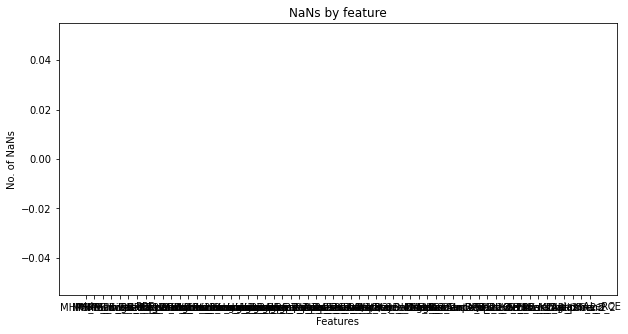

In [20]:
nan_data = features_nan_filled.isna().sum()
#print(nan_data)
y = nan_data
x = list(features_nan_filled.columns)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("No. of NaNs")
plt.title("NaNs by feature")
plt.show()

As we can see no more NaNs exist and as such we are ready to store this fully preprocessed dataset into a csv to then be used by classification models.

In [21]:
features_nan_filled.to_csv(pathData+'features_preprocessed.csv', encoding='utf-8', index=True)

# Read Features Preprocessed CSV

In [114]:
features_preprocessed = pd.read_csv(pathData + 'features_preprocessed.csv')
features_preprocessed.pop('Unnamed: 0')
features_preprocessed
features_preprocessed_cpy = features_preprocessed


# Classification

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
classes = features_preprocessed["classALeRCE"].to_frame()
#converting the classes to numbers
mapping = {'SLSN': 0, 'SNII_Joined': 1, 'SNIa': 2,'SNIbc':3}
classes = classes.replace({'classALeRCE': mapping})

classes = classes.to_numpy()
classes = classes.flatten()
print(classes)
#removing the class from the original dataframe
features_preprocessed_cpy = features_preprocessed_cpy.drop(['classALeRCE'], axis=1)
features_preprocessed_cpy = features_preprocessed_cpy.drop(['oid'], axis=1)
print(features_preprocessed_cpy)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

##Train Test split and Oversampling

In [117]:
X_train, X_test, y_train, y_test = train_test_split(features_preprocessed_cpy,classes,test_size=0.3,random_state=109)


In [118]:
!python -m pip install imbalanced-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Visualizing umber of samples of each class before oversampling

['SNIa' 'SNIa' 'SNIa' 'SNII_Joined' 'SNII_Joined' 'SNII_Joined' 'SNIa'
 'SNII_Joined' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNII_Joined'
 'SNII_Joined' 'SNII_Joined' 'SNIa' 'SNIa' 'SLSN' 'SNIa' 'SNIa' 'SNIa'
 'SNIa' 'SNII_Joined' 'SNII_Joined' 'SNII_Joined' 'SNIa' 'SLSN' 'SNIa'
 'SNIa' 'SNIa' 'SNIbc' 'SLSN' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa'
 'SNIa' 'SNIbc' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIbc' 'SNII_Joined' 'SNIbc'
 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa'
 'SNII_Joined' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa' 'SNIa'
 'SNIa' 'SNIa' 'SNIbc' 'SNIa' 'SNIa' 'SNII_Joined' 'SNIa' 'SNIa' 'SNIa'
 'SNII_Joined' 'SNIa' 'SNII_Joined' 'SNIa' 'SNIa' 'SNIa' 'SNIa'
 'SNII_Joined' 'SNII_Joined' 'SNIa' 'SNII_Joined' 'SNII_Joined'
 'SNII_Joined' 'SNII_Joined' 'SNII_Joined' 'SNIa' 'SNIa' 'SNIbc' 'SNIa'
 'SNIa' 'SNII_Joined' 'SNIa' 'SNIa' 'SNII_Joined' 'SLSN' 'SNIa' 'SNIa'
 'SNII_Joined' 'SNIa' 'SNIa' 'SNIa' 'SNII_Joined' 'SNIa' 'SNII_Joined'
 'SNIa' 'SNIa' 'SNIa' 'SNIa'

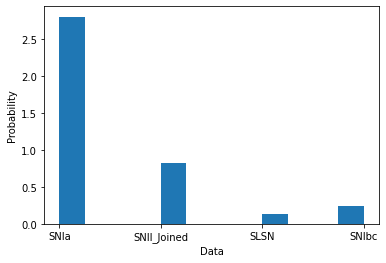

In [119]:
classes = []
classes = np.array(classes)
mapping = {'SLSN': 0, 'SNII_Joined': 1, 'SNIa': 2,'SNIbc':3}

for i in range(0,len(y_train)):
  if y_train[i] == 0:
    classes=np.append(classes,'SLSN')
  if y_train[i] == 1:
    classes=np.append(classes,'SNII_Joined')
  if y_train[i] == 2:
    classes=np.append(classes,'SNIa')
  if y_train[i] == 3:
    classes=np.append(classes,'SNIbc')

print(classes)
    


plt.hist(classes, density=True, bins=12)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [120]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 

oversample = RandomOverSampler(sampling_strategy='all')

#X_over, y_over = oversample.fit_resample(X_train, y_train)

sm = SMOTE(random_state=42)
X_over, y_over = sm.fit_resample(X_train, y_train)

print(X_over)
print(X_train)

      MHPS_ratio_2  MHPS_low_2  MHPS_high_2  MHPS_non_zero_2  MHPS_PN_flag_2  \
0        -0.004609    0.097657     0.018799         0.042077       -0.117329   
1        -0.004077    0.035004    -0.005900        -0.055851        0.882671   
2        -0.004845   -0.064313    -0.009683        -0.052085       -0.117329   
3        -0.004858   -0.064496    -0.006243        -0.006887       -0.117329   
4        -0.004462   -0.038734    -0.008882         0.068442       -0.117329   
...            ...         ...          ...              ...             ...   
1087     -0.003836   -0.045997    -0.009713        -0.047362       -0.117329   
1088     -0.003973    0.072352    -0.002197         0.077056       -0.117329   
1089     -0.003319   -0.018372    -0.009204        -0.044190       -0.117329   
1090     -0.003760    0.174590    -0.002733         0.049610       -0.117329   
1091     -0.003278   -0.018450    -0.009294        -0.044036       -0.117329   

      Multiband_period           PPE  P

['SNIa' 'SNIa' 'SNIa' ... 'SNIbc' 'SNIbc' 'SNIbc']


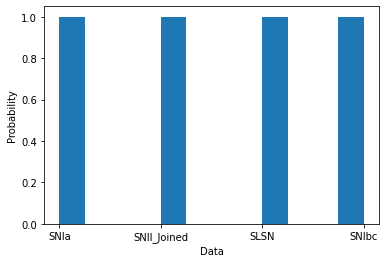

In [121]:
classes = []
classes = np.array(classes)
mapping = {'SLSN': 0, 'SNII_Joined': 1, 'SNIa': 2,'SNIbc':3}

for i in range(0,len(y_over)):
  if y_over[i] == 0:
    classes=np.append(classes,'SLSN')
  if y_over[i] == 1:
    classes=np.append(classes,'SNII_Joined')
  if y_over[i] == 2:
    classes=np.append(classes,'SNIa')
  if y_over[i] == 3:
    classes=np.append(classes,'SNIbc')

print(classes)
    


plt.hist(classes, density=True, bins=12)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

## Feature Selection with Random Forest

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [123]:
clf = RandomForestClassifier(
    n_estimators=1000,
    criterion="gini",
    max_depth=3,
    max_features="sqrt",
    n_jobs=-1,
    class_weight="balanced"
)

#clf.fit(X_train, y_train)
clf.fit(X_over, y_over)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       max_features='sqrt', n_estimators=1000, n_jobs=-1)


Promedio recall por clase (validacion) 0.540
Promedio recall por clase (training) 0.666
Numero de ejemplos en validacion clasificados correctamente: 111

Caracteristicas ordenadas por importancia (RF)
	0.095 Multiband_period
	0.094 Period_band_2
	0.086 LinearTrend_2
	0.049 MHPS_ratio_2
	0.049 GP_DRW_tau_2
	0.047 PairSlopeTrend_2
	0.041 MedianBRP_2
	0.033 MHPS_low_2
	0.032 Harmonics_mse_2
	0.032 SF_ML_amplitude_2
	0.029 Power_rate_4
	0.028 MHPS_PN_flag_2
	0.023 MedianAbsDev_2
	0.023 Power_rate_3
	0.022 MHPS_non_zero_2
	0.021 Power_rate_1/3
	0.019 StetsonK_2
	0.018 Power_rate_2
	0.018 ExcessVar_2
	0.016 Pvar_2
	0.015 iqr_2
	0.014 MHPS_high_2
	0.013 Psi_CS_2
	0.013 Mean_2
	0.013 Q31_2
	0.013 Psi_eta_2
	0.012 delta_period_2
	0.012 Harmonics_phase_3_2
	0.011 Power_rate_1/2
	0.011 IAR_phi_2
	0.010 SF_ML_gamma_2
	0.008 Autocor_length_2
	0.007 Harmonics_phase_7_2
	0.007 Power_rate_1/4
	0.007 AndersonDarling_2
	0.006 PPE
	0.006 Std_2
	0.006 Rcs_2
	0.005 Meanvariance_2
	0.005 Beyond1Std_2
	0.00

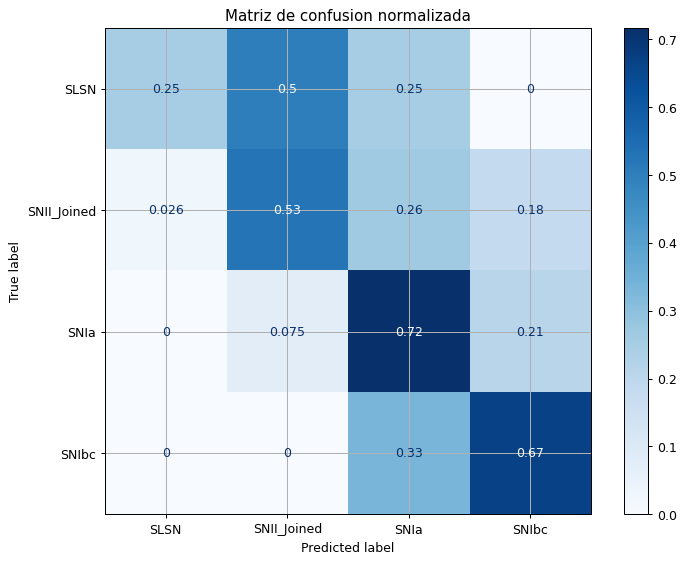

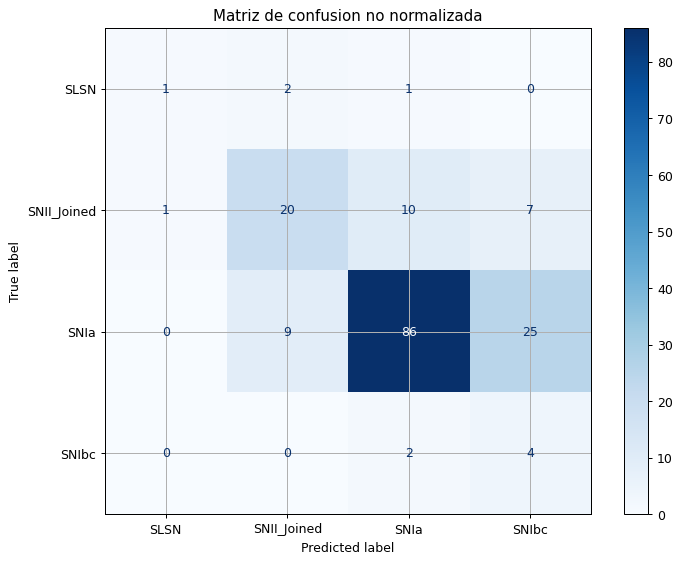

In [124]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

def plot_confusion_matrix(
    y_test,
    y_pred,
    classes,
    normalize=True,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), dpi=90)
        fig.tight_layout()

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap=plt.cm.Blues,
        normalize="true" if normalize else None,
        ax=ax
    )
    
    title = f"Matriz de confusion{' no' if not normalize else ''} normalizada"
    
    ax.set_title(title)
    # ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)
    ax.set_yticks(tick_marks, classes)

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.grid("off")

def mean_recall(cm):
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    return cm.diagonal().mean()

target_names = [
    "SLSN",
    "SNII_Joined",
    "SNIa",
    "SNIbc"
]

plot_confusion_matrix(y_test, y_pred, target_names, normalize=True)
plot_confusion_matrix(y_test, y_pred, target_names, normalize=False)

print(f"\nPromedio recall por clase (validacion) {mean_recall(cm):.3f}")

y_train_pred = clf.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)

print(f"Promedio recall por clase (training) {mean_recall(train_cm):.3f}")

print("Numero de ejemplos en validacion clasificados correctamente: %d" % accuracy_score(y_test, y_pred, normalize=False))
print("\nCaracteristicas ordenadas por importancia (RF)")
feature_importances = clf.feature_importances_
importance_order = np.argsort(-feature_importances)
feature_names = [
"MHPS_ratio_2",
"MHPS_low_2",
"MHPS_high_2",
"MHPS_non_zero_2",
"MHPS_PN_flag_2",
"Multiband_period",
"PPE",
"Period_band_2",
"delta_period_2",
"GP_DRW_sigma_2", 
"GP_DRW_tau_2",
"Psi_CS_2",
"Psi_eta_2",
"Harmonics_mag_1_2",
"Harmonics_mag_2_2",
"Harmonics_mag_3_2",
"Harmonics_mag_4_2",
"Harmonics_mag_5_2",
"Harmonics_mag_6_2",
"Harmonics_mag_7_2",
"Harmonics_phase_2_2",
"Harmonics_phase_3_2",
"Harmonics_phase_4_2",
"Harmonics_phase_5_2",
"Harmonics_phase_6_2",
"Harmonics_phase_7_2",
"Harmonics_mse_2",
"iqr_2",
"Power_rate_1/4",
"Power_rate_1/3",
"Power_rate_1/2",
"Power_rate_2",
"Power_rate_3",
"Power_rate_4",
"Amplitude_2",
"AndersonDarling_2",
"Autocor_length_2",
"Beyond1Std_2",
"Con_2",
"Gskew_2",
"Mean_2",
"Meanvariance_2",
"MedianAbsDev_2",
"MedianBRP_2",
"PairSlopeTrend_2",
"PercentAmplitude_2",
"Q31_2",
"Rcs_2",
"Skew_2",
"SmallKurtosis_2",
"Std_2",
"StetsonK_2",
"Pvar_2",
"ExcessVar_2",
"SF_ML_amplitude_2",
"SF_ML_gamma_2",
"IAR_phi_2",
"LinearTrend_2"]
for index in importance_order:
    print(f"\t{feature_importances[index]:.3f} {feature_names[index]}")

Now we will keep only 80% importance features

In [125]:
total_importance = 0.6
importance = 0
important_features = np.empty(0)
important_features_names = []


for index in importance_order:
    #print(f"\t{feature_importances[index]:.3f} {feature_names[index]}")
    importance += feature_importances[index]
    important_features = np.append(important_features,int(index))
    important_features_names = np.append(important_features_names,feature_names[index])
    if importance >= total_importance:
      break
important_features = important_features.astype(int)

print('Features with a total sum of ' + str(total_importance) + ' importance:')
for index in important_features:
  print(f"\t{feature_importances[index]:.3f} {feature_names[index]}")
print('\nTotal number of features: ' + str(len(important_features)))

Features with a total sum of 0.6 importance:
	0.095 Multiband_period
	0.094 Period_band_2
	0.086 LinearTrend_2
	0.049 MHPS_ratio_2
	0.049 GP_DRW_tau_2
	0.047 PairSlopeTrend_2
	0.041 MedianBRP_2
	0.033 MHPS_low_2
	0.032 Harmonics_mse_2
	0.032 SF_ML_amplitude_2
	0.029 Power_rate_4
	0.028 MHPS_PN_flag_2

Total number of features: 12


In [126]:
feature_to_keep = []
for index in important_features:
  feature_to_keep.append(feature_names[index])

X_train = X_train.filter(feature_to_keep)
X_over = X_over.filter(feature_to_keep)

X_test = X_test.filter(feature_to_keep)
print(X_train)

     Multiband_period  Period_band_2  LinearTrend_2  MHPS_ratio_2  \
214         -0.055478      -0.120332       0.032144     -0.004609   
240         -0.056926      -0.082880       0.136675     -0.004077   
290         -0.056858      -0.079675       0.064272     -0.004845   
21          -0.056566      -0.121045      -0.070713     -0.004858   
27          -0.055491       0.878707      -0.010534     -0.004462   
..                ...            ...            ...           ...   
260         -0.056875      -0.121247      -0.036738     -0.004840   
399         -0.056903      -0.121265      -0.124471     -0.004859   
141         -0.056892      -0.121258      -0.033669     -0.004860   
245         -0.055527      -0.120364      -0.017585     -0.004844   
262         -0.056920      -0.121277       0.043110     -0.004765   

     GP_DRW_tau_2  PairSlopeTrend_2  MedianBRP_2  MHPS_low_2  Harmonics_mse_2  \
214     -0.001892          0.108618     0.044543    0.097657        -0.000866   
240     -

## SVM

In [127]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(C=1, kernel='rbf', gamma=0.5, probability=True) # Gaussian Kernel

#Train the model using the training sets
clf.fit(X_over, y_over)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

##Model Evaluation

In [128]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Balanced Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Balanced Precision:",metrics.precision_score(y_test, y_pred, average='macro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Balanced Recall:",metrics.recall_score(y_test, y_pred, average='macro'))

Balanced Accuracy: 0.4285087719298246
Balanced Precision: 0.3837065833033575
Balanced Recall: 0.4285087719298246


Confusion Matrix

Confusion matrix, without normalization
[[ 1  1  1  1]
 [ 9 17  8  4]
 [ 1 13 62 44]
 [ 0  0  3  3]]
Normalized confusion matrix
[[0.25       0.25       0.25       0.25      ]
 [0.23684211 0.44736842 0.21052632 0.10526316]
 [0.00833333 0.10833333 0.51666667 0.36666667]
 [0.         0.         0.5        0.5       ]]


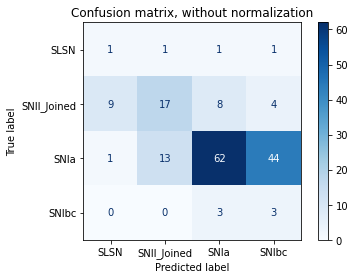

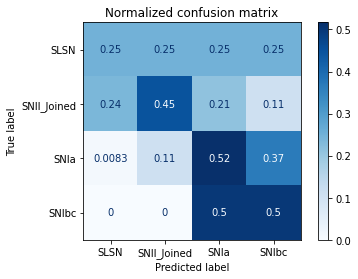

In [129]:
# Plot non-normalized confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels= ["SLSN","SNII_Joined","SNIa","SNIbc"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Random Forest

In [145]:
clf = RandomForestClassifier(
    n_estimators=1000,
    criterion="gini",
    max_depth=3,
    max_features="sqrt",
    n_jobs=-1,
    class_weight= "balanced",
    
)

clf.fit(X_over, y_over)

RandomForestClassifier(max_depth=3, max_features='sqrt', n_estimators=1000,
                       n_jobs=-1)


Promedio recall por clase (validacion) 0.472
Promedio recall por clase (training) 0.636
Numero de ejemplos en validacion clasificados correctamente: 104

Caracteristicas ordenadas por importancia (RF)
	0.182 Multiband_period
	0.145 Period_band_2
	0.138 LinearTrend_2
	0.078 MHPS_ratio_2
	0.076 PairSlopeTrend_2
	0.072 MedianBRP_2
	0.065 MHPS_low_2
	0.059 SF_ML_amplitude_2
	0.057 GP_DRW_tau_2
	0.049 Power_rate_4
	0.048 Harmonics_mse_2
	0.031 MHPS_PN_flag_2


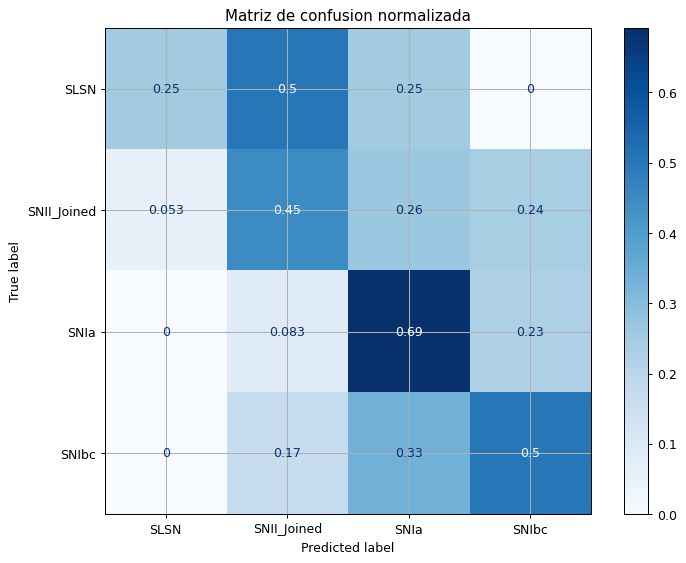

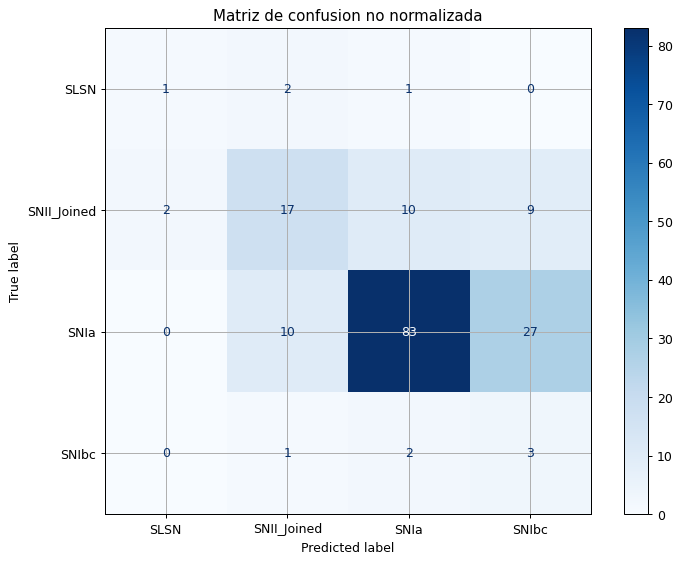

In [146]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

def plot_confusion_matrix(
    y_test,
    y_pred,
    classes,
    normalize=True,
    ax=None,
  
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), dpi=90)
        fig.tight_layout()

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap=plt.cm.Blues,
        normalize="true" if normalize else None,
        ax=ax
    )
    
    title = f"Matriz de confusion{' no' if not normalize else ''} normalizada"
    
    ax.set_title(title)
    # ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)
    ax.set_yticks(tick_marks, classes)

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.grid("off")

def mean_recall(cm):
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    return cm.diagonal().mean()

target_names = [
    "SLSN",
    "SNII_Joined",
    "SNIa",
    "SNIbc"
]

plot_confusion_matrix(y_test, y_pred, target_names, normalize=True)
plot_confusion_matrix(y_test, y_pred, target_names, normalize=False)

print(f"\nPromedio recall por clase (validacion) {mean_recall(cm):.3f}")

y_train_pred = clf.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)

print(f"Promedio recall por clase (training) {mean_recall(train_cm):.3f}")

print("Numero de ejemplos en validacion clasificados correctamente: %d" % accuracy_score(y_test, y_pred, normalize=False))
print("\nCaracteristicas ordenadas por importancia (RF)")
feature_importances = clf.feature_importances_
importance_order = np.argsort(-feature_importances)
feature_names = important_features_names
#feature_names = feature_names
for index in importance_order:
    print(f"\t{feature_importances[index]:.3f} {feature_names[index]}")

In [147]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Balanced Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Balanced Precision:",metrics.precision_score(y_test, y_pred, average='macro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Balanced Recall:",metrics.recall_score(y_test, y_pred, average='macro'))

Balanced Accuracy: 0.4722587719298246
Balanced Precision: 0.46037660256410257
Balanced Recall: 0.4722587719298246


## K-NN

In [148]:
 #Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
clf = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test) 


Promedio recall por clase (validacion) 0.481
Promedio recall por clase (training) 0.571
Numero de ejemplos en validacion clasificados correctamente: 132


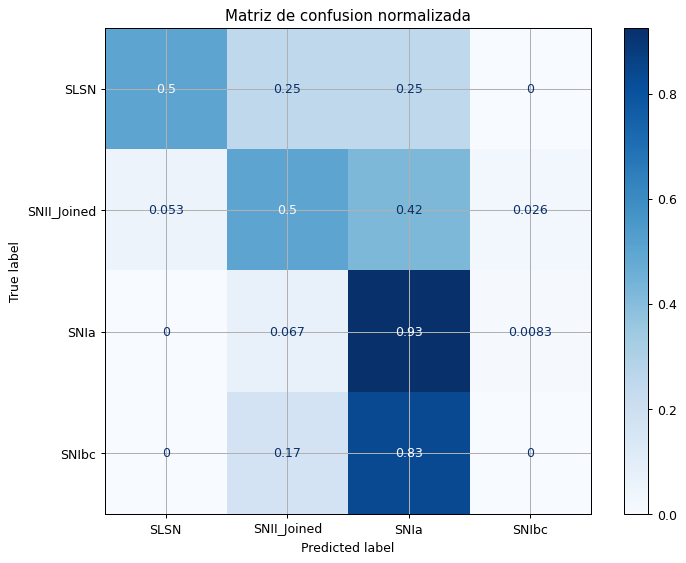

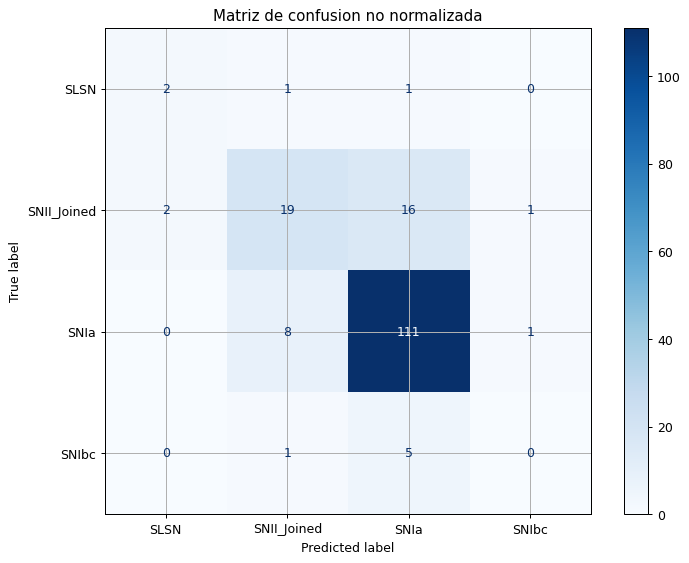

In [149]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

def plot_confusion_matrix(
    y_test,
    y_pred,
    classes,
    normalize=True,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), dpi=90)
        fig.tight_layout()

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap=plt.cm.Blues,
        normalize="true" if normalize else None,
        ax=ax
    )
    
    title = f"Matriz de confusion{' no' if not normalize else ''} normalizada"
    
    ax.set_title(title)
    # ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)
    ax.set_yticks(tick_marks, classes)

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.grid("off")

def mean_recall(cm):
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    return cm.diagonal().mean()

target_names = [
    "SLSN",
    "SNII_Joined",
    "SNIa",
    "SNIbc"
]

plot_confusion_matrix(y_test, y_pred, target_names, normalize=True)
plot_confusion_matrix(y_test, y_pred, target_names, normalize=False)

print(f"\nPromedio recall por clase (validacion) {mean_recall(cm):.3f}")

y_train_pred = clf.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)

print(f"Promedio recall por clase (training) {mean_recall(train_cm):.3f}")

print("Numero de ejemplos en validacion clasificados correctamente: %d" % accuracy_score(y_test, y_pred, normalize=False))

In [150]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Balanced Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Balanced Precision:",metrics.precision_score(y_test, y_pred, average='macro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Balanced Recall:",metrics.recall_score(y_test, y_pred, average='macro'))

Balanced Accuracy: 0.48125
Balanced Precision: 0.4974397199896292
Balanced Recall: 0.48125


Counting the time needed to run (without taking into account the extraction of features)

In [151]:

t2 = time.perf_counter()
print('time taken to run:',t2-t1)

time taken to run: 4949.881801298
